In [1]:
import pandas as pd
import numpy as np
atom_dict = {
    12: 'Mg',
    13: 'Al',
    20: 'Ca',
    22: 'Ti',
    23: 'V',
    24: 'Cr',
    25: 'Mn',
    26: 'Fe',
    27: 'Co',
    28: 'Ni',
    29: 'Cu',
    30: 'Zn',
    38: 'Sr',
    56: 'Ba',
}
def get_data(p):
    df = pd.read_csv('%s.csv' % p)
    df.atom_list = df.atom_list.apply(lambda x: list(map(int, x.split(','))))
    for an, name in atom_dict.items():
        df[name] = df.atom_list.apply(lambda x: x.count(an) / len(x))
    X = df[atom_dict.values()]
    y = df[p]
    return df, X, y

# XGBoost

# T90

In [2]:
import xgboost
df, X, y = get_data('T90')
model = xgboost.XGBRegressor()

leave one out cross validation

In [3]:
y_true = []
y_predict = []
for i in range(len(X)):
    df_train = df[~df.index.isin([i])]
    X_train = df_train[atom_dict.values()]
    y_train = df_train['T90']
    df_test = df[df.index.isin([i])]
    X_test = df_test[atom_dict.values()]
    y_test = df_test['T90']
    model.fit(X_train, y_train)
    y_predict.append(model.predict(X_test)[0])
    y_true.append(y_test.iloc[0])
#result = cross_val_score(model, X, y, cv=105)
#for i in range(10):
#    result = np.r_[result, cross_val_score(clf, X, y, cv=10)]
df_loocv = pd.DataFrame({
    'y_true': y_true,
    'y_predict': y_predict
})
df_loocv.to_csv('T90_loocv.csv', index=False)

In [4]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
print(r2_score(y_true, y_predict))
print(mean_absolute_error(y_true, y_predict))
print(np.sqrt(mean_squared_error(y_true, y_predict)))

0.15214341335790338
39.78636852446056
60.23106789049751


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


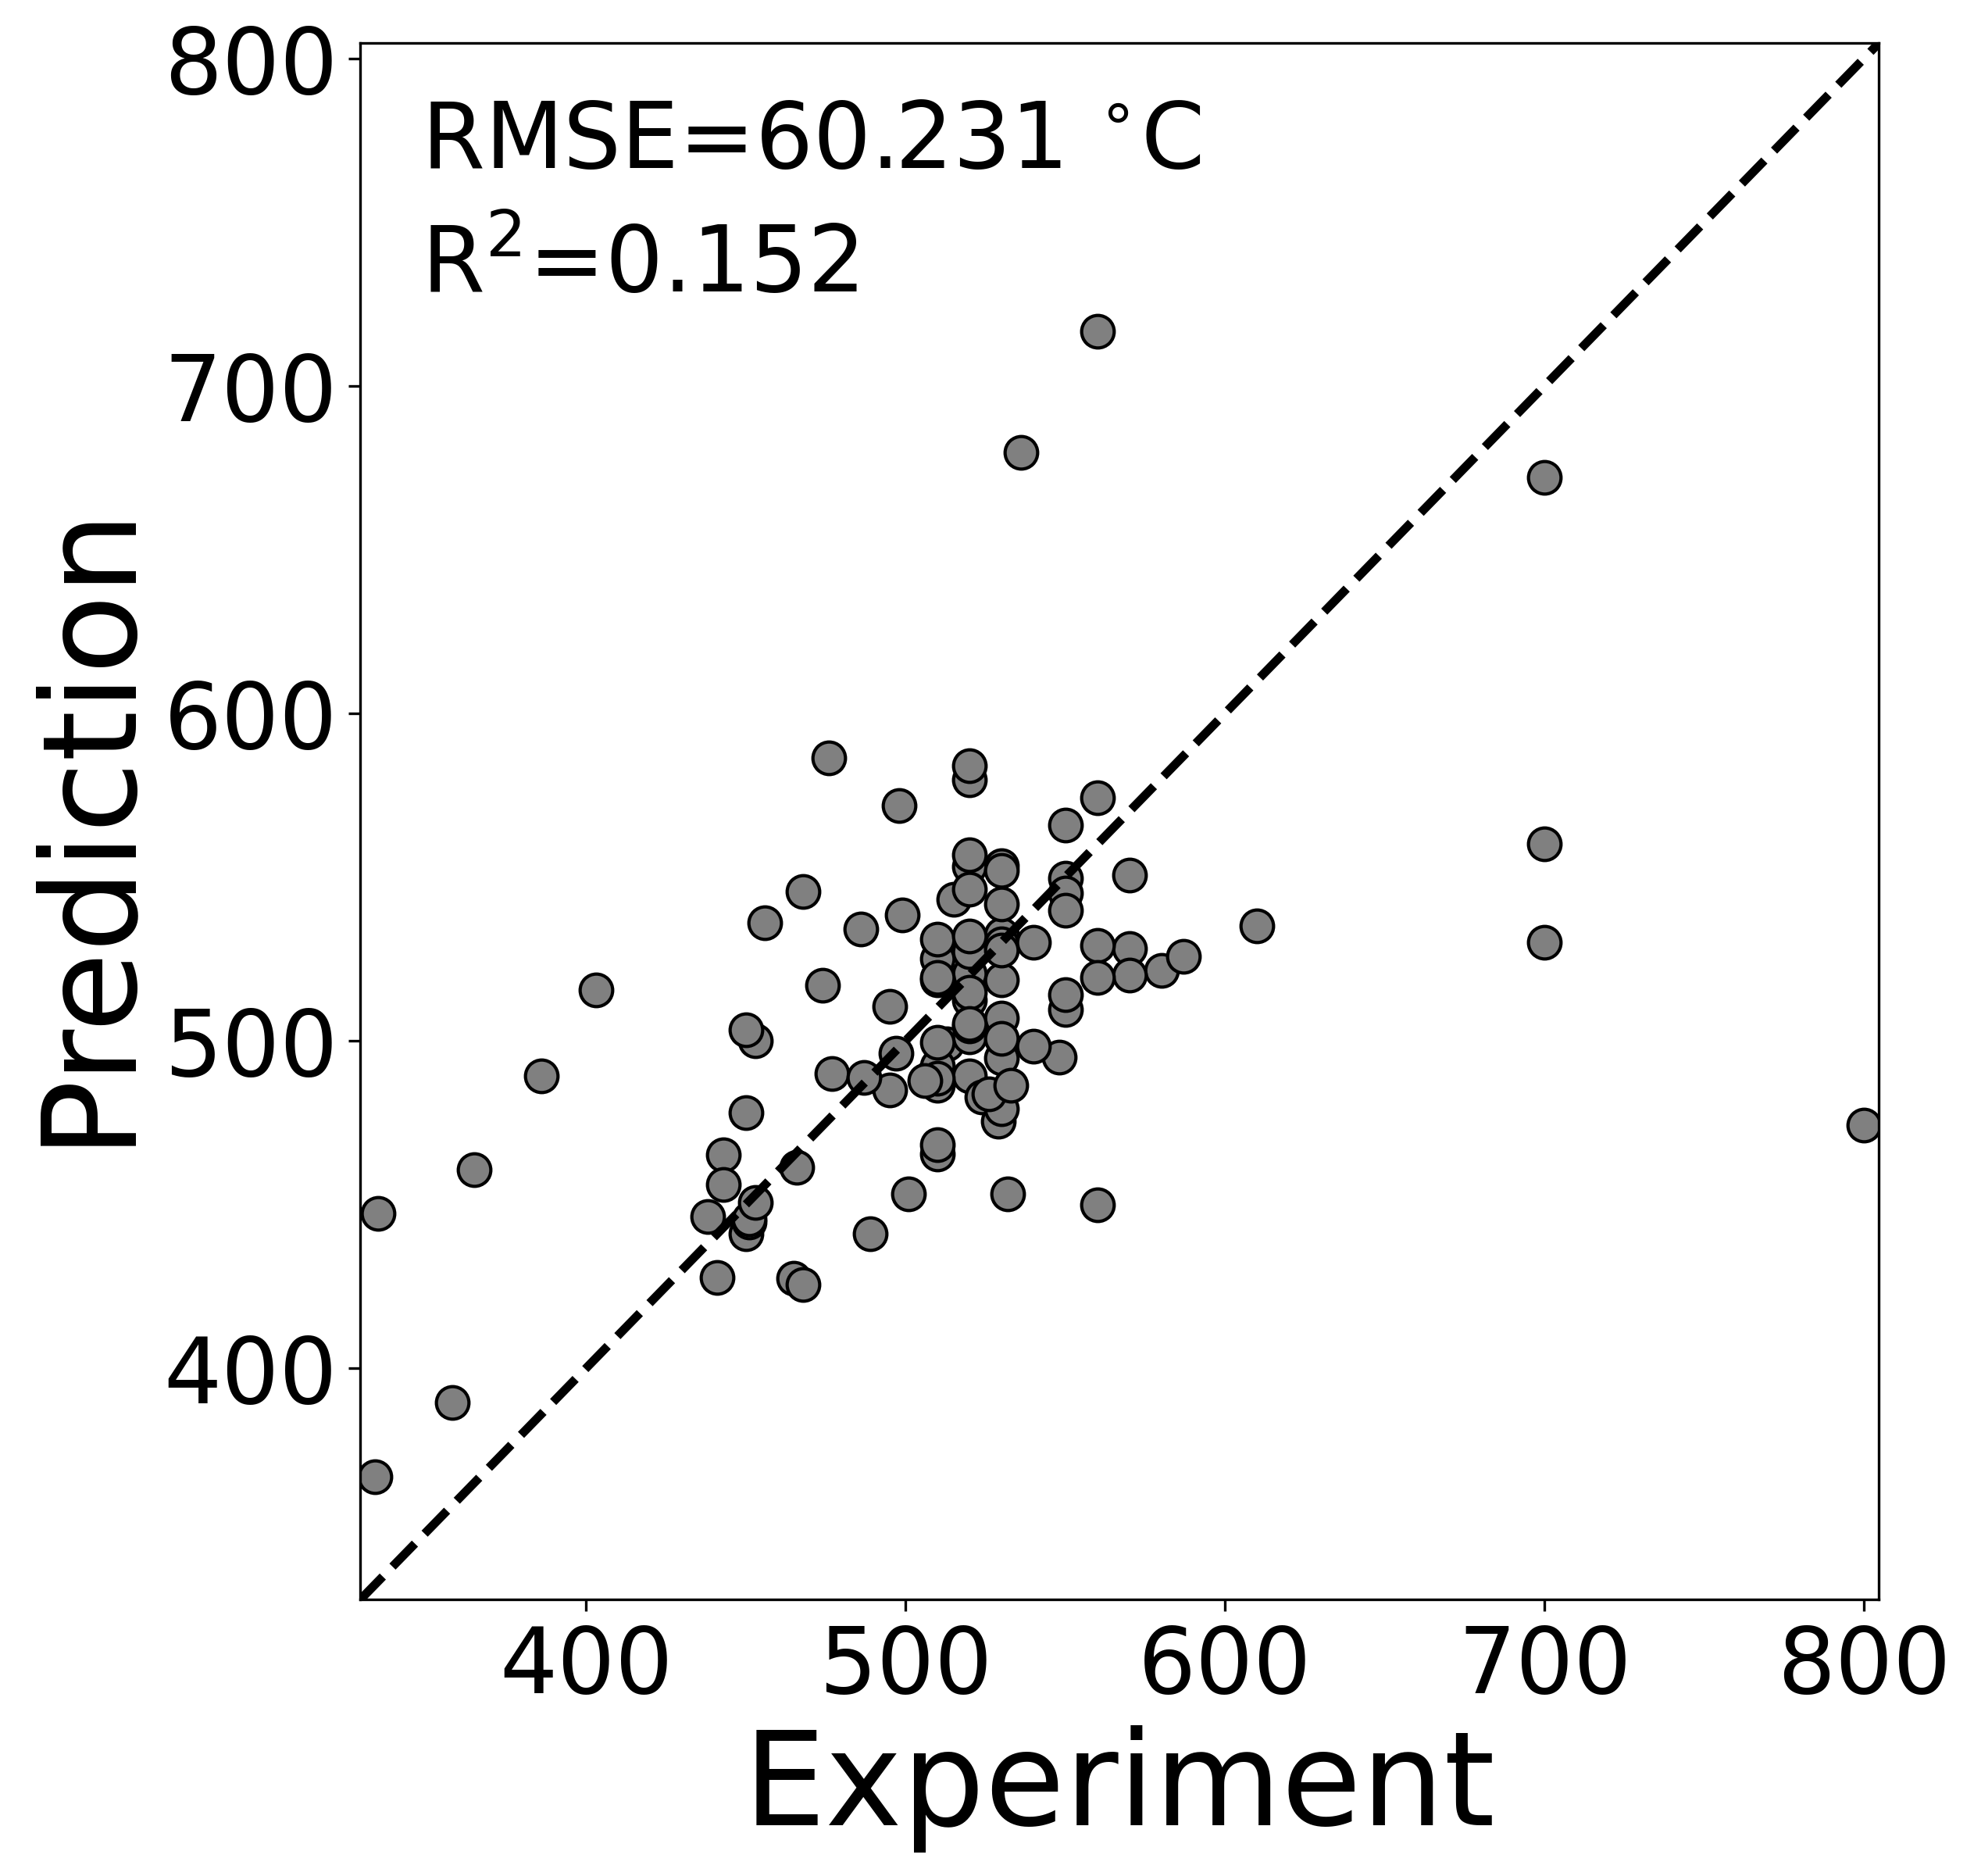

In [5]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
fs = 8
params = {'legend.fontsize': '%s' % (4. * fs),
          'figure.figsize': (fs * 1, fs),  # 8*6
          'axes.labelsize': '%s' % (5 * fs),
          'axes.titlesize': '%s' % (5 * fs),
          'xtick.labelsize': '%s' % (3.5 * fs),
          'ytick.labelsize': '%s' % (3.5 * fs),
          'font.family': 'serif',
          'font.serif': 'Calibri',
          'savefig.dpi': 300,
          'figure.dpi': 300,
          }
pylab.rcParams.update(params)
fig = plt.figure()
fig.tight_layout()
dxs = [0.16, 0.03]  # left to right
dx = (1 - sum(dxs)) / (len(dxs) - 1)
dys = [0.14, 0.03]  # down to top
dy = (1 - sum(dys)) / (len(dys) - 1)
nx = 1
ny = 1
ax = fig.add_axes([sum(dxs[:nx]) + (nx - 1) * dx, sum(dys[:ny]) + (ny - 1) * dy, dx, dy])
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))
def plotxy(ax, X, Y, size=1.0, color=None, square=False, xlabel=None,
           ylabel=None, type='scatter', alpha=1.0, label=None, linestyle=None,
           fontsize=20):
    X = np.asarray(X)
    Y = np.asarray(Y)
    lx = X.min()
    ux = X.max()
    ly = Y.min()
    uy = Y.max()
    if square:
        lx = ly = min(lx, ly)
        ux = uy = max(ux, uy)
    dx = (ux - lx)
    dy = (uy - ly)
    if type == 'scatter':
        ax.scatter(X, Y, s=size, c=color, alpha=alpha, label=label, edgecolor='k')
    elif type == 'line':
        ax.plot(X, Y, c=color, linewidth=size, linestyle=linestyle, label=label,
                alpha=alpha)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    ax.tick_params()
    ax.set_xlim(lx - dx * 0.01, ux + dx * 0.01)
    ax.set_ylim(ly - dy * 0.01, uy + dy * 0.01)
    return lx - dx * 0.01, ux + dx * 0.01, dx * 1.02, ly - dy * 0.01, uy + dy * 0.01, dy * 1.02
l, u, d, _, _, _ = plotxy(ax, y_true, y_predict, square=True, size=100, color='gray')
ax.plot([l, u], [l, u], c='k', linestyle='--', linewidth=fs/3)
ax.text(l + 0.04 * d, u - 0.08 * d,
        r'RMSE=%.3f $^{\circ}$C' % (rmse(y_true, y_predict)),
        fontsize=fs*3.5, color='k')
ax.text(l + 0.04 * d, u - 0.16 * d,
        r'R$^2$=%.3f' % (r2_score(y_true, y_predict)),
        fontsize=fs*3.5, color='k')
ax.set_xlabel('Experiment')
ax.set_ylabel('Prediction')
plt.savefig('figure_T90_LOOCV.png')

/home/xiangyan/apps/miniconda3/envs/hes_3.6/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


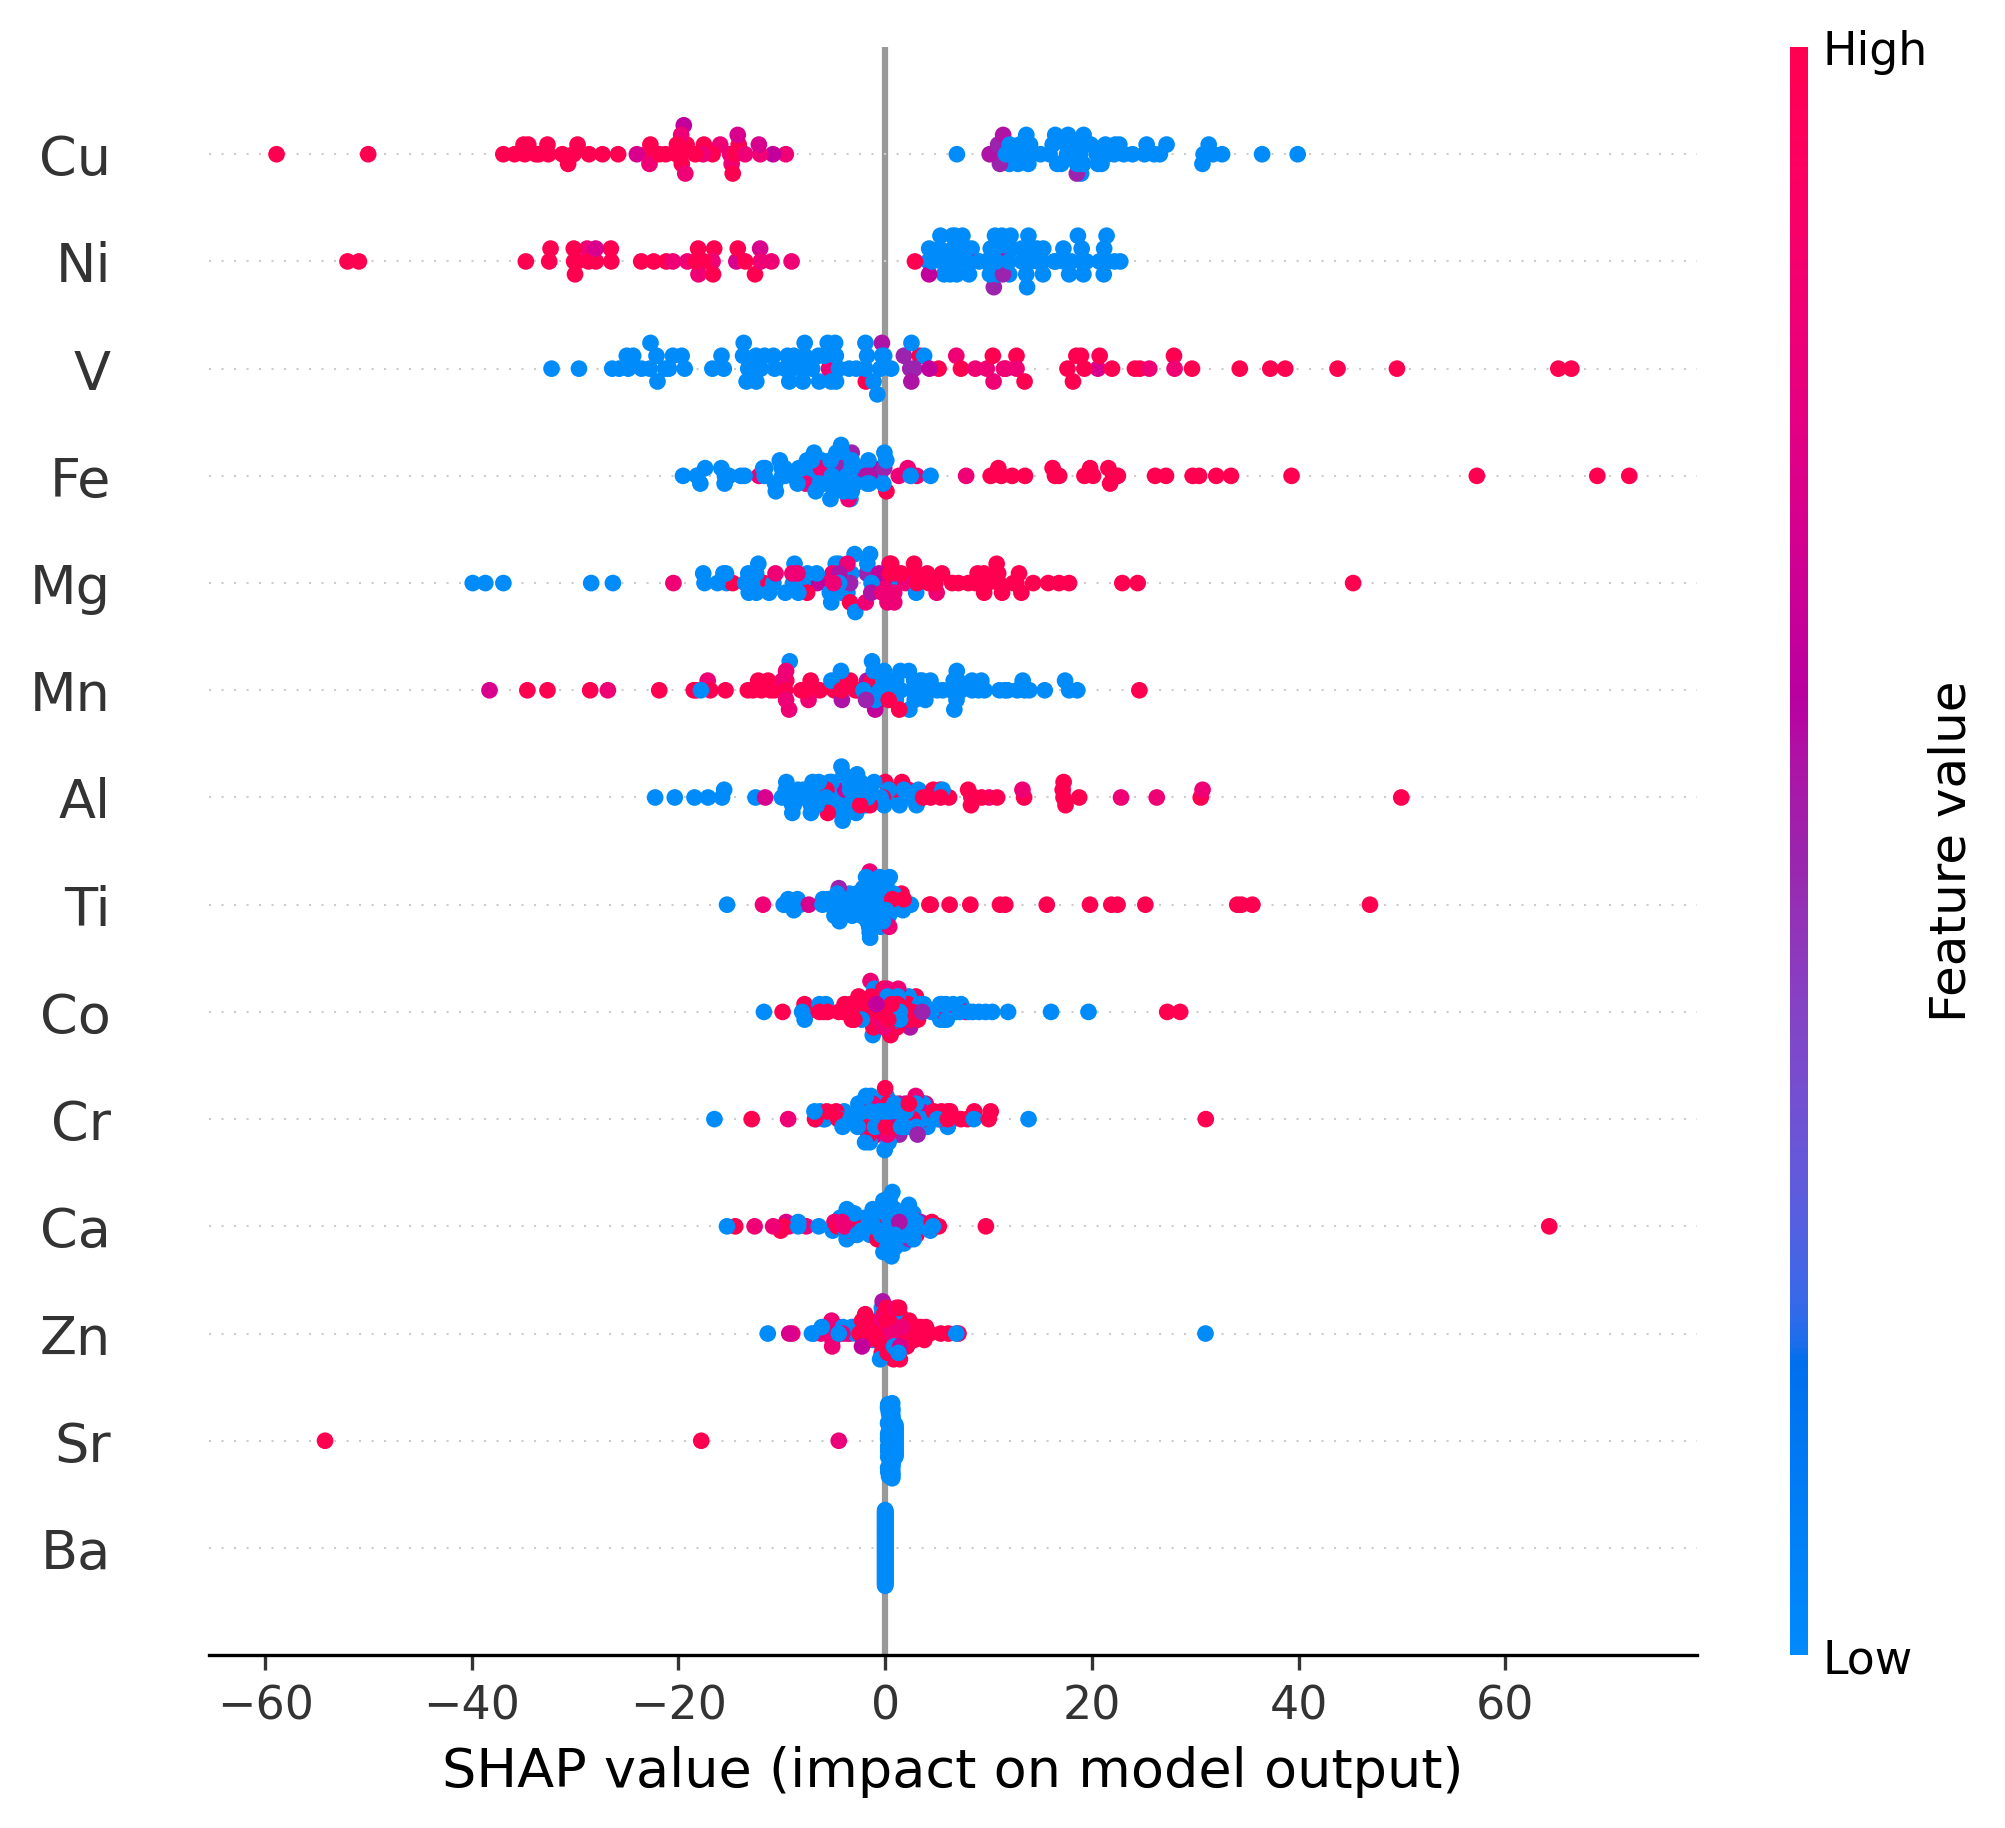

In [6]:
import shap
shap.initjs()
def shap_ana(clf, X, y):
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X)
    shap.summary_plot(shap_values, X, show=False)
    plt.savefig('figure_T90_shap.png')
    return explainer, shap_values
model.fit(X, y)
explainer, shap_values = shap_ana(model, X, y)
